In [3]:
import numpy as np
import matplotlib.pyplot as plt
from data.load_from_csv import get_content_datasets
import pandas as pd
from datetime import datetime
from src.models.baselines.baseline_utils import run_baseline
import theano.tensor as tt
import pymc3 as pm

% matplotlib inline

/Users/zac/miniconda3/envs/psj/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
from definitions import HUMAN_DATA_DIR

In [6]:
## Question data
datasets = get_content_datasets(task='fermi', sparsity='unmasked')
train_dataset, val_dataset, test_dataset = datasets

## Answers
answerset = pd.read_csv(os.path.join(HUMAN_DATA_DIR, 'fermi', 'answers.csv')).drop('Unnamed: 0', axis=1).set_index('item_id').T.to_dict('index')['answer']

In [7]:
train_dataset.item_ids[0]
print(train_dataset.item_text[3])
print(answerset[3])

area of rectangle with sides 10 units and 6 units * 146 < 23,900
True


In [8]:
def make_df(dataset, answerset):
    users = []
    questions = []
    times = []
    opinions = []
    answers = []

    for datum in dataset:
        for i, rating in enumerate(datum['rating']):
            if not np.isnan(rating):
                users.append(datum['user_id'])
                questions.append(datum['item_id'])
                answers.append(answerset[datum['item_id']])
                times.append(i)
                opinions.append(rating)

    data = pd.DataFrame(data={'user':users,
                              'question': questions,
                              'time': times,
                              'opinion': opinions,
                              'answer': answers})
    
    return data

In [9]:
data = make_df(train_dataset, answerset)
val_data = make_df(val_dataset, answerset)
question_ids = data.question.unique()
question_idx = data['question'].values
user_ids = data.user.unique()

slow_responses = data[data.time == 2]

## Real data

In [10]:
response_data = []
obs_counts = []

max_responses = 0
max_responder = -1
max_responder_accuracy = -1

for user in user_ids:
    user_response = slow_responses.loc[data.user == user][['opinion', 'answer']].values

    right_wrong = []
    count = 0
    for response in user_response:
        if response[0] > 0.5 and response[1] == True:
            right_wrong.append(1)
            count += 1

        elif response[0] < 0.5 and response[1] == False:
            right_wrong.append(1)
            count += 1

        elif response[0] == 0.5:
            continue

        else:
            right_wrong.append(0)
            count += 1

    if len(right_wrong) > 0:
        response_data.append(sum(right_wrong))
        obs_counts.append(count)

    if len(user_response) > max_responses:
        max_responses = len(user_response)
        max_responder = user
        max_responder_accuracy = np.mean(right_wrong)
        print(user, max_responses, max_responder_accuracy)

1 28 0.7777777777777778
6 48 0.8809523809523809
19 90 0.7954545454545454
74 297 0.8204225352112676


## Fake data

In [11]:
fake_response_data = []
fake_obs_counts = []
p = 0.735
"""
p_good = 0.5
p_high = 0.8
p_low = 0.6
"""
for i in range(10):
    for user in user_ids:
        """
        is_good = np.random.binomial(1, p_good)

        if is_good:
            p = p_high

        else:
            p = p_low
        """
        #p = np.random.beta(16,6)
        user_response = slow_responses.loc[data.user == user][['opinion', 'answer']].values
        right_wrong = []
        count = 0
        """
        for i in range(10):
            right_wrong.append(np.random.binomial(1, p))
            count += 1

        """
        for response in user_response:
            if response[0] == 0.5:
                continue

            else:
                right_wrong.append(np.random.binomial(1, p))
                count += 1


        if len(right_wrong) > 0:
            fake_response_data.append(sum(right_wrong))
            fake_obs_counts.append(count)
    

## Inference

In [12]:
## Priors
#alpha = 1
#beta = 1

In [13]:
## Real data
num_users = len(response_data)

with pm.Model() as model:
    alpha = pm.HalfNormal('alpha', sd=5)
    beta = pm.HalfNormal('beta', sd=5)
    
    user_skills = pm.Beta('skills', 
                          alpha=alpha, 
                          beta=beta, 
                          shape=num_users)
    
    obs = pm.Binomial('obs',
                      p=user_skills, 
                      n=obs_counts, 
                      observed=response_data)      
    
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [skills_logodds__, beta_log__, alpha_log__]
The number of effective samples is smaller than 25% for some parameters.


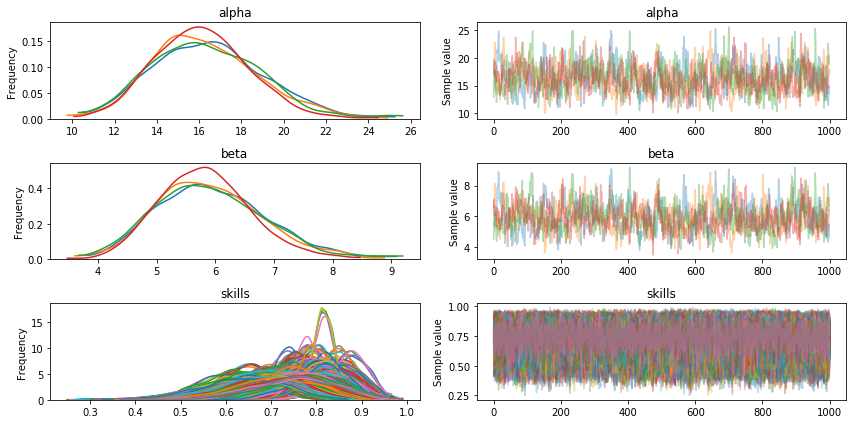

In [11]:
pm.traceplot(trace)
plt.show()

In [12]:
## Fake data
num_users = len(fake_response_data)
with pm.Model() as fake_data_model:
    fake_alpha = pm.HalfNormal('fake_alpha', sd=5)
    fake_beta = pm.HalfNormal('fake_beta', sd=5)
    
    fake_user_skills = pm.Beta('fake_skills', 
                               alpha=fake_alpha, 
                               beta=fake_beta, 
                               shape=num_users)
    
    fake_obs = pm.Binomial('fake_obs', 
                           p=fake_user_skills, 
                           n=fake_obs_counts, 
                           observed=fake_response_data)      
    
    fake_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fake_skills_logodds__, fake_beta_log__, fake_alpha_log__]
The acceptance probability does not match the target. It is 0.6361644581794274, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8977881969269568, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6220038291228004, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


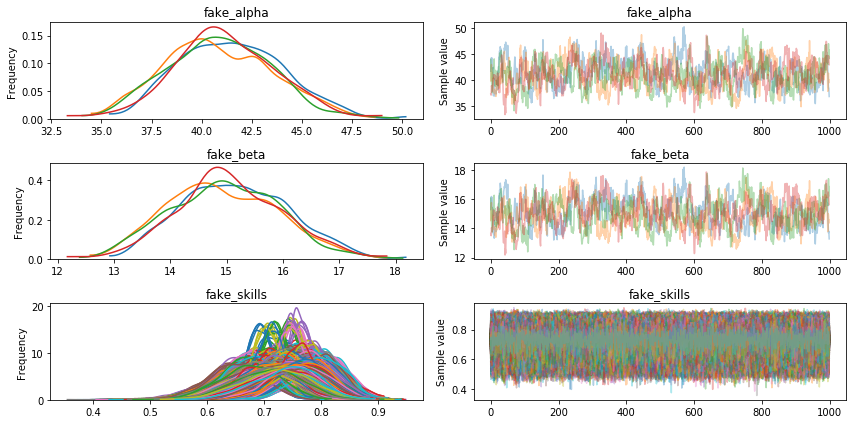

In [13]:
pm.traceplot(fake_trace)
plt.show()

## Plot skill distributions

In [14]:
means = np.mean(trace['skills'], axis=0)
stds = np.std(trace['skills'], axis=0)
hpds = pm.stats.hpd(trace['skills'])

p = means.argsort()
sort_means = means[p]
sort_stds = stds[p]
sort_hpds = hpds[p,:]
yerr_min = sort_means - sort_hpds[:,0]
yerr_max = sort_hpds[:,1] - sort_means
yerr = np.stack([yerr_min, yerr_max], axis=1).T

In [15]:
fake_means = np.mean(fake_trace['fake_skills'], axis=0)
fake_stds = np.std(fake_trace['fake_skills'], axis=0)
fake_hpds = pm.stats.hpd(fake_trace['fake_skills'])

p = fake_means.argsort()
fake_sort_means = fake_means[p]
fake_sort_stds = fake_stds[p]
fake_sort_hpds = fake_hpds[p,:]
fake_yerr_min = fake_sort_means - fake_sort_hpds[:,0]
fake_yerr_max = fake_sort_hpds[:,1] - fake_sort_means
fake_yerr = np.stack([fake_yerr_min, fake_yerr_max], axis=1).T

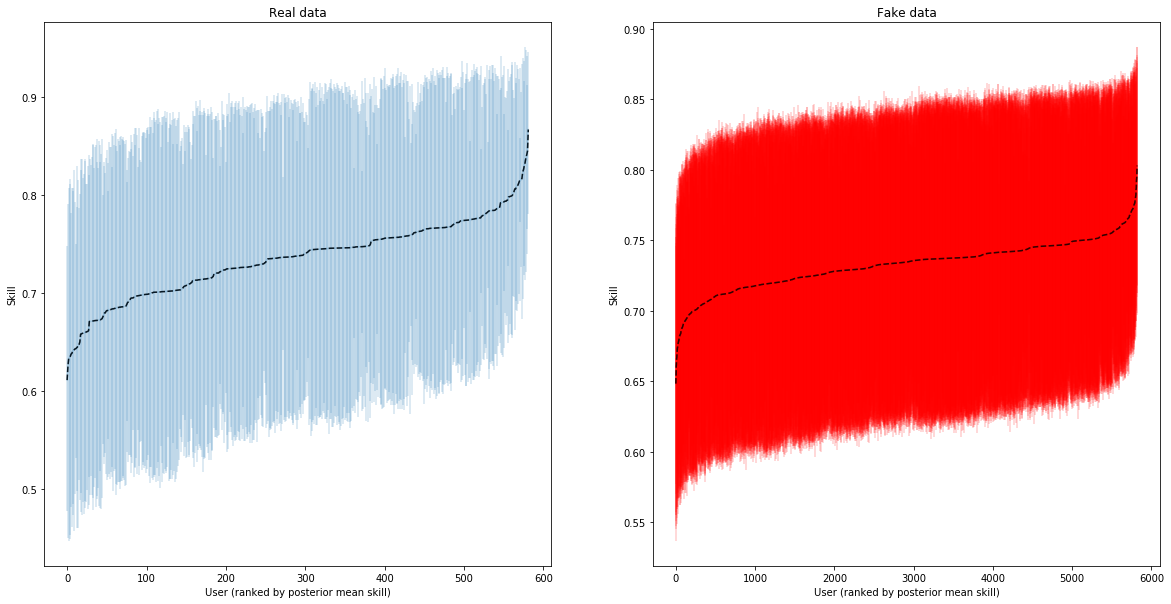

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

## Real data
axes[0].errorbar(np.arange(len(sort_means)),
              sort_means,
              yerr=yerr,
              alpha=0.2)

axes[0].plot(sort_means, c='k', ls='--')
axes[0].set_xlabel('User (ranked by posterior mean skill)')
axes[0].set_ylabel('Skill')
axes[0].set_title('Real data')

## Fake data
axes[1].errorbar(np.arange(len(fake_sort_means)),
              fake_sort_means,
              yerr=fake_yerr,
              alpha=0.2,
              c='r')

axes[1].plot(fake_sort_means, c='k', ls='--')
axes[1].set_xlabel('User (ranked by posterior mean skill)')
axes[1].set_ylabel('Skill')
axes[1].set_title('Fake data')
plt.show()

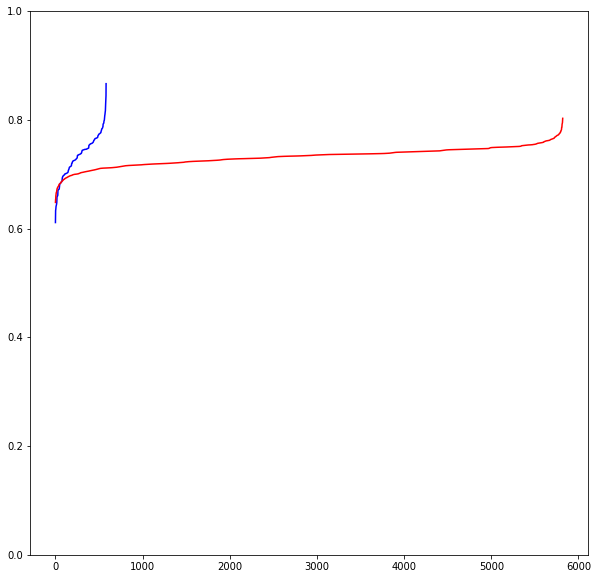

In [17]:
fig, axes = plt.subplots(1, figsize=(10,10))
axes.plot(sort_means, c='b')
axes.plot(fake_sort_means, c='r')
axes.set_ylim([0., 1.])
fig.savefig('real_vs_fake.svg')
plt.show()

## Plot inferred skill distribution

16.2861506947133 5.8929706159082595
41.076316839279045 15.02235328302787


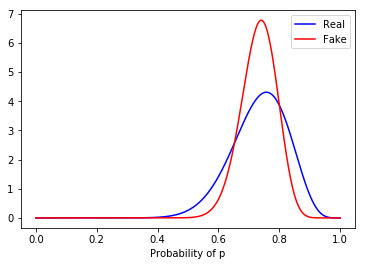

In [18]:
from scipy import stats

fig, axes = plt.subplots(1)
x = np.linspace(0,1,1000)

## Real data
alpha_pm = np.mean(trace['alpha'])
beta_pm = np.mean(trace['beta'])
print(alpha_pm, beta_pm)
axes.plot(x, stats.beta.pdf(x, alpha_pm, beta_pm), c='b', label='Real')

## Fake data
fake_alpha_pm = np.mean(fake_trace['fake_alpha'])
fake_beta_pm = np.mean(fake_trace['fake_beta'])
print(fake_alpha_pm, fake_beta_pm)
axes.plot(x, stats.beta.pdf(x, fake_alpha_pm, fake_beta_pm), c='r', label='Fake')

axes.legend()
axes.set_xlabel('Probability of p')
plt.show()

In [20]:
0

0